In [1]:
!pip install requests

                                              0.0/62.6 kB ? eta -:--:--
     ---------------------------------------- 62.6/62.6 kB 1.6 MB/s eta 0:00:00
                                              0.0/96.7 kB ? eta -:--:--
     ---------------------------------------- 96.7/96.7 kB 5.8 MB/s eta 0:00:00
                                              0.0/123.2 kB ? eta -:--:--
     -------------------------------------- 123.2/123.2 kB 7.1 MB/s eta 0:00:00
                                              0.0/157.0 kB ? eta -:--:--
     -------------------------------------- 157.0/157.0 kB 9.2 MB/s eta 0:00:00


In [15]:
!pip install nltk

In [16]:
import requests
import numpy as np
import pandas as pd
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

## 3. Utilizando el servicio del dataset de datos abiertos https://www.datos.gov.co/Ciencia-Tecnolog-a-e-Innovaci-n/Contenidos-Youtube/v98q-23dp, vamos a hacer un clasificador del tipo de contenido basados en el titulo:

### a. Crear un código python para invocar el servicio proporcionado y leer los datos en un dataframe (Puede utilizar la libreria request)

In [2]:
url = "https://www.datos.gov.co/resource/v98q-23dp.json?$query=SELECT%0A%20%20%60titulo%60%2C%0A%20%20%60descripcion%60%2C%0A%20%20%60url_lista_de_reproduccion%60%2C%0A%20%20%60plataforma%60"

In [3]:
response = requests.get(url)

Verificamos la respuesta y se guardamos los datos en un dataframe

In [4]:
if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data)
else:
    print("Error al obtener los datos: ", response.status_code)

In [20]:
data = pd.read_csv("data/dataPunto3.csv")

In [21]:
df = pd.DataFrame(data)

### La variable objetivo es predecir la columna categoria (Se debe transformar en Entretenimiento, Deportes, Película y Animación, Educación y Otros) utilizando el texto del titulo.

Se transforman los datos de la descripción 

In [22]:
i_categoria = set([i for i,v in
        zip(df["categoría"].value_counts().index, df["categoría"].value_counts().values) if v > 30 ])
df["categoría"].apply(lambda x: x if x in i_categoria else 'Otros').value_counts()

Entretenimiento         1672
Deportes                1565
Película y Animación    1381
Educación                945
Gente y Blogs            423
Música                   248
Viajes y Eventos          66
Otros                     49
Name: categoría, dtype: int64

renombramos las variables descripción

In [23]:
df = df.rename(columns={'categoría': 'categoria'})

### i. Utilizar todos los datos, y explorar el numero total de palabras únicas en todos los títulos de train y el numero total de repeticiones (Crear un diccionario para saber si la palabra ya fue observada antes e intentar remover tildes y poner el texto en minúsculas)

Creamos un diccionario para almacenar la frecuencia de palabras

In [24]:
palabrasFrecuentes = {}
palabras = {}
palabrasUnicas = {}

Creamos una función para elimines algunas caracteres espacial como tildes, numeros entre otros.

In [25]:
def cambioLetras(letra):
    letra = re.sub('[áäâà]', 'a', letra.lower())
    letra = re.sub('[éëêè]', 'e', letra)
    letra = re.sub('[íïîì]', 'i', letra)
    letra = re.sub('[óöôò]', 'o', letra)
    letra = re.sub('[úüûù]', 'u', letra)
    letra = re.sub('[^a-z]', ' ', letra)  
    letra = re.sub('\s+', ' ', letra) 
    return letra.strip()

iteramos sobre cada título

In [26]:
for titulo in df['titulo']:
    # Se limpia el texto
    cambiotitulo = cambioLetras(titulo)
    # Se divide el título en palabras individuales
    palabras = cambiotitulo.split()
    # Se crea un conjunto (set) de palabras únicas
    palabrasUnicas = set(palabras)

    # Se convierte el conjunto nuevamente a una lista
    palabrasUnicas = list(palabrasUnicas)

    # Se cuenta la frecuencia de cada palabra
    for palabra in palabras:
        if palabra in palabrasFrecuentes:
            palabrasFrecuentes[palabra] += 1
        else:
            palabrasFrecuentes[palabra] = 1

In [27]:
numeroDePalabrasUnicas = len(palabrasFrecuentes)
numeroRepeteciones = sum(palabrasFrecuentes.values())

Resultados

In [28]:
print("Número total de palabras únicas:", numeroDePalabrasUnicas)
print("Número total de repeticiones:", numeroRepeteciones)

Número total de palabras únicas: 5627
Número total de repeticiones: 45718


###  ¿Cuántas palabras hay en el data set?

In [29]:
print("Número total de palabras en el dataset:", numeroRepeteciones)

Número total de palabras en el dataset: 45718


### Generar la Matriz

Creamos un dataframe vacío con las palabras únicas como columnas

In [30]:
matriz = pd.DataFrame(columns=palabrasUnicas)

Se itera sobre cada título en el dataframe

In [31]:
for index, titulo in enumerate(df['titulo']):
    # Se limpia el texto
    cambiotitulo = cambioLetras(titulo)
    # Se divide el título en palabras individuales
    palabras = cambiotitulo.split()
    # Se cuenta la frecuencia de cada palabra en el título
    contarPalabras = {palabra: palabras.count(palabra) for palabra in palabrasUnicas}
    # Se convierten los resultados en un dataframe temporal
    tempDf = pd.DataFrame(contarPalabras, index=[index])
    # Se concatena el dataframe temporal con la matriz
    matriz = pd.concat([matriz, tempDf])

Asignamos los títulos

In [32]:
matriz.index = df['titulo']

Se muestra la matriz

In [33]:
print(matriz)

                                                   en ciclovia se la  \
titulo                                                                 
Urbílogo - Bogotá dominguera                        0        0  0  0   
Historias en bici - Sibaté pedalea su pasado        1        0  0  0   
Today in replay 18 de febrero                       0        0  0  0   
Documentales: 'Camilo, el cura guerrillero' - H...  0        0  1  0   
En cine nos vemos - Cuchillo de palo - Renate C...  1        0  0  0   
...                                                ..      ... .. ..   
En movimiento Capi?tulo 2 - Radio Numar             1        0  0  0   
Ser mamá es una labor que cambia la vida - Feli...  0        0  0  1   
Puerto Papel - El Final del Verano Parte I (Cap...  0        0  0  0   
El recorrido virtual de la Fórmula Renault 2.0 ...  0        0  0  1   
Señal Deportes celebrará el cumpleaños de la ci...  1        1  1  1   

                                                   celebrara os

### ii. Crear un gráfico de barras con las 10 palabras más comunes.

Obtenemos las 10 palabras más comunes y sus frecuencias

In [34]:
palabrasComunes = sorted(palabrasFrecuentes.items(), key=lambda x: x[1], reverse=True)[:10]
principalesPalabras = [palabra[0] for palabra in palabrasComunes]
numeroPalbras = [palabra[1] for palabra in palabrasComunes]

Se crea el grafico de barras

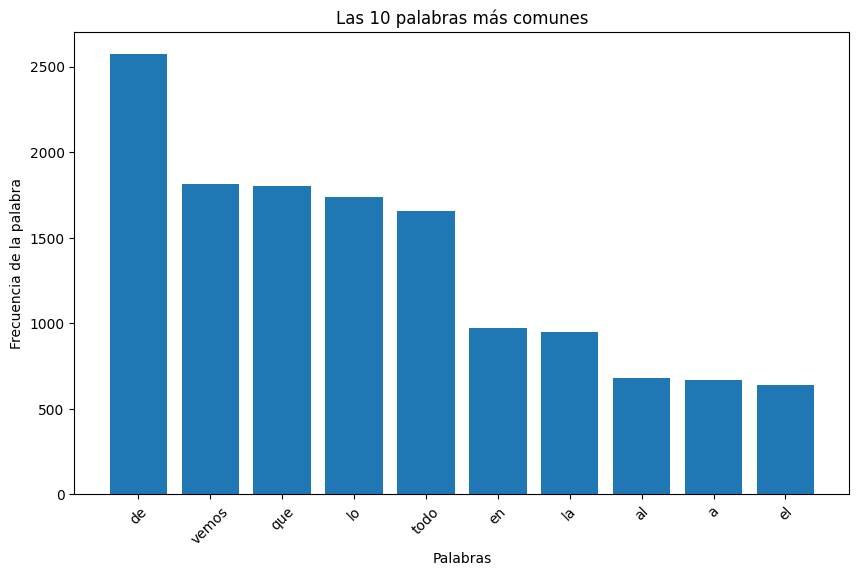

In [35]:
plt.figure(figsize=(10, 6))
plt.bar(principalesPalabras, numeroPalbras)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia de la palabra')
plt.title('Las 10 palabras más comunes')
plt.xticks(rotation=45) 
plt.show()

### ¿Son utiles?

Cuando se analizan las palabras más comunes en los títulos, a menudo se utilizan gráficos de barras para mostrar las frecuencias de las palabras de manera visual y rápida. Sin embargo, hay situaciones en las que un gráfico de barras puede no ser la opción más adecuada, especialmente cuando hay muchas palabras únicas y las frecuencias varían considerablemente.

### Normalmente las palabras más comunes son llamadas stop words. Y corresponden a los artículos o preposiciones. Generar nuevamente los gráficos. Y una matriz de correlación utilizando dummy variables para las variables objetivo “categoria”.

Creamos los dummy para la variable objetivo "Categoria"

In [36]:
dummy_categoria = pd.get_dummies(df['categoria'])

Se botienen las 10 palabras más comunes y sus frecuencias

In [37]:
palabrasComunes = sorted(palabrasFrecuentes.items(), key=lambda x: x[1], reverse=True)[:10]
principalesPalabras = [palabra[0] for palabra in palabrasComunes]
numeroPalbras = [palabra[1] for palabra in palabrasComunes]

Se crea el grafico de barras

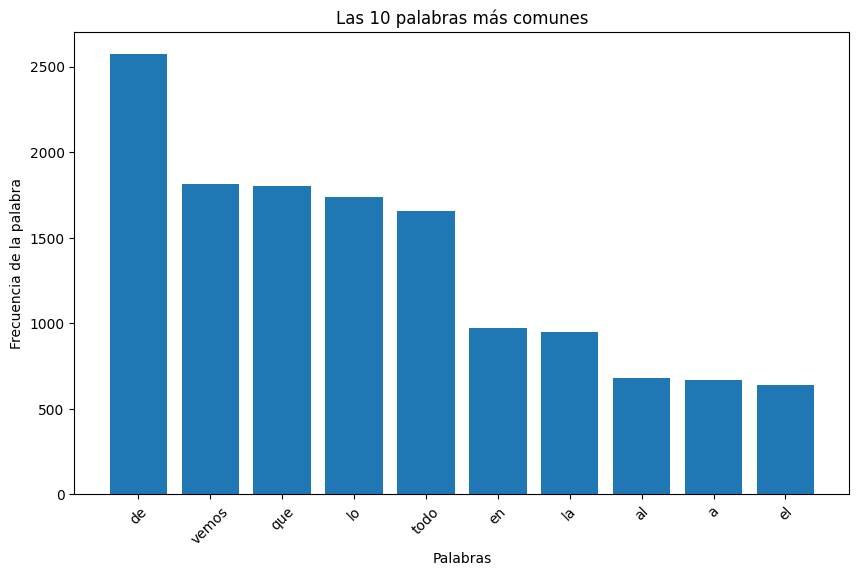

In [38]:
plt.figure(figsize=(10, 6))
plt.bar(principalesPalabras, numeroPalbras)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia de la palabra')
plt.title('Las 10 palabras más comunes')
plt.xticks(rotation=45) 
plt.show()

Creamos la matriz de correlación con los dummy variables

Text(0.5, 1.0, 'Matriz de correlación')

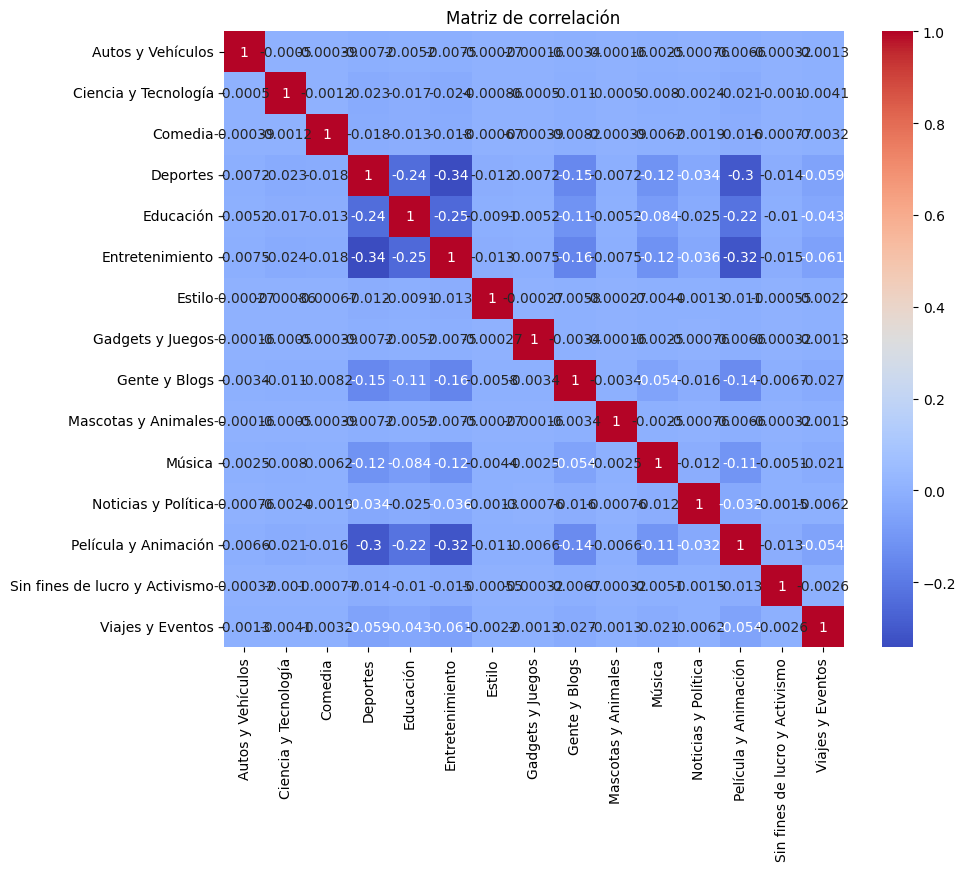

In [40]:
correlacion_matriz = dummy_categoria.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlacion_matriz, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')

### También generar la matriz nueva eliminando los stopwords y dividimos por el numero total de palabras en cada título. Esta matriz se llama TF (Term Frequency).

Descargamos los datos de las stopwords

In [41]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\J.Diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Obtenemos los stopwords en español

In [42]:
stopwords = stopwords.words('spanish')

Eliminamos los stopwords de las palabras únicas

In [43]:
palabrasUnicas = [palabra for palabra in palabrasUnicas if palabra not in stopwords]

Creamos un dataframe vacío con las palabras únicas en columnas

In [44]:
matriz = pd.DataFrame(columns=palabrasUnicas)

Iteramos en cada título

In [55]:
for index, titulo in enumerate(df['titulo']):
    # Se limpia el texto
    cambiotitulo = cambioLetras(titulo)
    # Se divide el título en palabras individuales
    palabras = cambiotitulo.split()
    # Se eliminan los stopwords de las palabras
    palabras = [palabra for palabra in palabras if palabra not in stopwords]
    
    if len(palabras) > 0:
        totalPalabras = len(palabras)
        # Se calcula la frecuencia de cada palabra en el título y dividir por el número total de palabras
        contarPalabras = {palabra: palabras.count(palabra) / totalPalabras for palabra in palabrasUnicas}
        # Se convierten los resultados en un dataframe temporal
        tempDf = pd.DataFrame(contarPalabras, index=[index])
        # Se concatena el dataframe temporal con la matriz
        matriz = pd.concat([matriz, tempDf])

In [59]:
df = df.drop_duplicates(subset='titulo')  # Eliminar duplicados en el DataFrame df
df.reset_index(drop=True, inplace=True)  # Restablecer los índices del DataFrame df

# Volver a generar el DataFrame matrix con los datos actualizados de df
matriz = pd.DataFrame(columns=palabrasUnicas)
for index, titulo in enumerate(df['titulo']):
    cambiotitulo = cambioLetras(titulo)
    palabras = cambiotitulo.split()
    contarPalabras = {palabra: palabras.count(palabra) / len(palabras) if len(palabras) != 0 else 0 for palabra in palabrasUnicas}
    tempDf = pd.DataFrame(contarPalabras, index=[index])
    matriz = pd.concat([matriz, tempDf])

In [60]:
matriz.index = df['titulo']

In [61]:
print(matriz)

                                                    ciclovia  celebrara  \
titulo                                                                    
Urbílogo - Bogotá dominguera                        0.000000   0.000000   
Historias en bici - Sibaté pedalea su pasado        0.000000   0.000000   
Today in replay 18 de febrero                       0.000000   0.000000   
Documentales: 'Camilo, el cura guerrillero' - H...  0.000000   0.000000   
En cine nos vemos - Cuchillo de palo - Renate C...  0.000000   0.000000   
...                                                      ...        ...   
En movimiento Capi?tulo 2 - Radio Numar             0.000000   0.000000   
Ser mamá es una labor que cambia la vida - Feli...  0.000000   0.000000   
Puerto Papel - El Final del Verano Parte I (Cap...  0.000000   0.000000   
El recorrido virtual de la Fórmula Renault 2.0 ...  0.000000   0.000000   
Señal Deportes celebrará el cumpleaños de la ci...  0.083333   0.083333   

                        

### iii. Ahora vamos a crear un vector contando el numero de titulos que tiene cada palabra. Este vector tiene “n” elementos y el valor es el número de títulos que tiene la palabra.

Creamos un vector para contar el número de títulos que contienen cada palabra

In [62]:
numeroTitulos = []

In [63]:
for palabra in palabrasUnicas:
    # Contar el número de títulos que contienen la palabra
    contar = sum(matriz[palabra] > 0)
    numeroTitulos.append(contar)

Vector del conteo

In [64]:
print(numeroTitulos)

[1, 1, 7, 148, 36]


### Por último vamos a transformar el numero calculando el log(Total de documentos/ (Numero de documentos con la Palabra i + 1) ). El +1 es para q no quede el numero indeterminado cuando algún valor es “0”, el vector es llamado IDF(Inverse Document Frequency)

Creamos una matriz vacía con las palabras únicas como columnas

In [65]:
idfMatriz = np.zeros((len(df), len(palabrasUnicas)))

In [66]:
for i, palabra in enumerate(palabrasUnicas):
    # Calcular el IDF para la palabra
    idf = np.log(len(df) / (numeroTitulos[i] + 1))
    # Asignar el IDF a la columna correspondiente en la matriz
    idfMatriz[:, i] = idf

convertimos la matriz en un DataFrame de pandas con los títulos como índices

In [67]:
idfDf = pd.DataFrame(idfMatriz, index=df['titulo'], columns=palabrasUnicas)

In [68]:
print(idfDf)

                                                    ciclovia  celebrara  \
titulo                                                                    
Urbílogo - Bogotá dominguera                        8.039641   8.039641   
Historias en bici - Sibaté pedalea su pasado        8.039641   8.039641   
Today in replay 18 de febrero                       8.039641   8.039641   
Documentales: 'Camilo, el cura guerrillero' - H...  8.039641   8.039641   
En cine nos vemos - Cuchillo de palo - Renate C...  8.039641   8.039641   
...                                                      ...        ...   
En movimiento Capi?tulo 2 - Radio Numar             8.039641   8.039641   
Ser mamá es una labor que cambia la vida - Feli...  8.039641   8.039641   
Puerto Papel - El Final del Verano Parte I (Cap...  8.039641   8.039641   
El recorrido virtual de la Fórmula Renault 2.0 ...  8.039641   8.039641   
Señal Deportes celebrará el cumpleaños de la ci...  8.039641   8.039641   

                        

### iv. Ahora vamos a multiplicar el vector TF (La matriz) * IDF (Vector transpuesto), El resultado es una matriz de m títulos por n palabras. Y dividir el dataset en test y train. En producción se debería dividir los datos antes de calcular el TF-IDF , y para calcular la matriz TFIDF en testing es necesario calcular la frecuencia de las palabras en testing utilizando el orden y las palabras en training y utilizar el IDF de training, pero no es necesario para esta tarea.

Eliminanos los valores que estan nulos 

In [69]:
df = df.dropna(subset=['titulo'])

Reindexar el dataframe después de eliminar los valores nulos

In [70]:
df = df.reset_index(drop=True)

dividemos los datos en entrenamiento y prueba

In [71]:
X_train, X_test, y_train, y_test = train_test_split(df['titulo'], df['categoria'], test_size=0.2, random_state=42)

creamos el vectorizador TF-IDF

In [79]:
tfidfVectorizer = TfidfVectorizer(stop_words=None)

Transformamos los datos de entrenamiento

In [80]:
tfidfTrain = tfidfVectorizer.fit_transform(X_train)

Transformamos los datos de prueba

In [81]:
tfidfTest = tfidfVectorizer.transform(X_test)

In [82]:
print("Dimensiones de la matriz TF-IDF de entrenamiento:", tfidfTrain.shape)
print("Dimensiones de la matriz TF-IDF de prueba:", tfidfTest.shape)

Dimensiones de la matriz TF-IDF de entrenamiento: (4962, 5555)
Dimensiones de la matriz TF-IDF de prueba: (1241, 5555)


### v. Utilizando la matriz vamos a entrenar 3 modelos, una regresión logística, un random forest y un GBM. Vamos a crear una matriz de confusión y vamos a comparar los 3 modelos. ¿Cuál es el mejor modelo?, incluir métricas como accuracy, precision y recall para cada modelo

In [83]:
scaler = StandardScaler(with_mean=False)
tfidf_train_scaled = scaler.fit_transform(tfidfTrain)
tfidf_test_scaled = scaler.transform(tfidfTest)

Modelo de regrecion logistica

In [85]:
regrecionLogistica = LogisticRegression(max_iter=7000)
regrecionLogistica.fit(tfidfTrain, y_train)
prediccionRegrecion = regrecionLogistica.predict(tfidfTest)

Generamos el accuracy el precision y el recall

In [87]:
regrecionLogisticaAccuracy = accuracy_score(y_test, prediccionRegrecion)
regrecionLogisticaprecision = precision_score(y_test, prediccionRegrecion, average='weighted', zero_division=1)
regrecionLogisticaRecall = recall_score(y_test, prediccionRegrecion, average='weighted')

Creamos la matriz de confusion pa el modelo de regresion 

In [88]:
regrecionLogisticaMatriz = confusion_matrix(y_test, prediccionRegrecion)

In [89]:
print("Regresión Logística")
print("Accuracy:", regrecionLogisticaAccuracy)
print("Precision:", regrecionLogisticaprecision)
print("Recall: ", regrecionLogisticaRecall)
print("Matriz de Confusión")
print(regrecionLogisticaMatriz)

Regresión Logística
Accuracy: 0.797743755036261
Precision: 0.8062943247098213
Recall:  0.797743755036261
Matriz de Confusión
[[  0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   1   1   0   0   0   0   0]
 [  0   0 270   4   7   0   0   0  10   0   0]
 [  0   0   4 116  40   5   1   0  13   0   0]
 [  0   0  11   8 287   1   2   0  25   0   0]
 [  0   0   4   8  22  52   0   0   9   0   0]
 [  0   0   1   3   7   1  25   0   7   0   0]
 [  0   0   0   0   2   2   0   3   0   0   0]
 [  0   0   4   5  31   0   0   0 234   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   1   1   3   3   0   0   2   0   3]]


Modelo random forest

In [91]:
randomForest = RandomForestClassifier(min_samples_split=50, min_samples_leaf=1)

In [94]:
randomForest.fit(tfidf_train_scaled, y_train)

RandomForestClassifier(min_samples_split=50)

In [95]:
randomForestPredecido = randomForest.predict(tfidf_test_scaled)

In [98]:
randomForestAccuracy = accuracy_score(y_test, randomForestPredcion)
randomForestPrecision = precision_score(y_test, randomForestPredcion, average='weighted', zero_division=1)
randomForestRecall = recall_score(y_test, randomForestPredcion, average='weighted', zero_division=1)

Creamos la matriz de confusion pa el modelo de random forest 

In [99]:
randomForestMatriz = confusion_matrix(y_test, randomForestPredcion)

In [100]:
print("Random Forest")
print("Accuracy:", randomForestAccuracy)
print("Precision:", randomForestPrecision)
print("Recall:", randomForestRecall)
print("Matriz de Confusión")
print(randomForestMatriz)

Random Forest
Accuracy: 0.7880741337630943
Precision: 0.7981792743066167
Recall: 0.7880741337630943
Matriz de Confusión
[[  0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   1   1   0   0   0   0   0]
 [  0   0 268  12   7   0   0   0   4   0   0]
 [  0   0   2 123  45   4   1   0   4   0   0]
 [  0   0   4  24 283   4   0   0  18   0   1]
 [  0   0   3   6  20  54   0   0  11   0   1]
 [  0   0   2   1   9   1  27   0   4   0   0]
 [  0   0   0   2   1   1   0   3   0   0   0]
 [  0   0  14  18  31   1   0   0 210   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   1   1   1   0   0   0   0   0  10]]


Modelo de GBM

In [101]:
gbm = GradientBoostingClassifier(min_samples_split=50, min_samples_leaf=1, learning_rate=0.4)

In [102]:
gbm.fit(tfidf_train_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.4, min_samples_split=50)

Realizamos la predicion en los datos de prueba

In [106]:
gbmPredicion = gbm.predict(tfidf_test_scaled)

In [108]:
gbmAccuracy = accuracy_score(y_test, gbmPredicion)
gbmPrecision = precision_score(y_test, gbmPredicion, average='weighted', zero_division=1)
gbmRecall = recall_score(y_test, gbmPredicion, average='weighted', zero_division=1)

Creamos la matriz de confusion pa el modelo de GBM

In [109]:
gbmMatriz = confusion_matrix(y_test, gbmPredicion)

In [110]:
print("GBM")
print("Accuracy:", gbmAccuracy)
print("Precision:", gbmPrecision)
print("Recall:", gbmRecall)
print("Matriz de Confusión")
print(gbmMatriz)

GBM
Accuracy: 0.7590652699435939
Precision: 0.772117280090111
Recall: 0.7590652699435939
Matriz de Confusión
[[  0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   1   1   0   0   0   0]
 [  0   0 248   1   9   2   3   1  27   0   0]
 [  0   0   1 100  46   6   3   1  21   0   1]
 [  0   0   6   6 268   8   8   1  35   0   2]
 [  0   0   4   1  14  63   4   0   9   0   0]
 [  0   0   0   2   4   2  30   0   5   0   1]
 [  0   0   0   0   0   1   3   3   0   0   0]
 [  0   0   3   9  28   7   3   0 223   0   1]
 [  0   0   0   0   0   0   0   0   0   1   0]
 [  0   0   1   1   0   3   0   0   2   0   6]]


### ¿Cuál es el mejor modelo?

Al comparar resultados de los diferentes modelos Random Forest GBM y regrecion logistica podemos ver que:
El "Accuracy" nos indica qué tan precisas son las predicciones del modelo. En el caso de Random Forest, su exactitud es del 76.8%, lo que significa que el 69.5%% de las predicciones del modelo son correctas. 

La "Precision" es una medida que nos dice cuántas de las muestras clasificadas como positivas son realmente positivas. Para Random Forest, la precisión es del 77.9%, lo que indica que hay menos falsos positivos en comparación con los otros modelos.

El "recall" nos indica la capacidad del modelo para identificar correctamente las muestras positivas. En este caso, el recall nos da un valor de 69.5. lo que significa que tienen una capacidad similar para evitar falsos negativos.

En conclucion los tres modelos rojan valores entre el 60% - el 70% sin embargo el randon forest ojala los valores mas altos siendo el  mejor modelo en este caso Tiene la mayor exactitud y precisión, lo que sugiere que sus predicciones son más confiables y hay menos falsos positivos. 